In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from tempfile import TemporaryDirectory
import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Загрузка и нормализация данных

In [2]:
train_transform = transforms.Compose(
    [# transforms.RandomHorizontalFlip(p=0.5),
     # transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
datasets = {"train": train_set, "val": val_set}

batch_size = 32

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=8) for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Давайте ради интереса покажем несколько изображений в тренировочных данных.

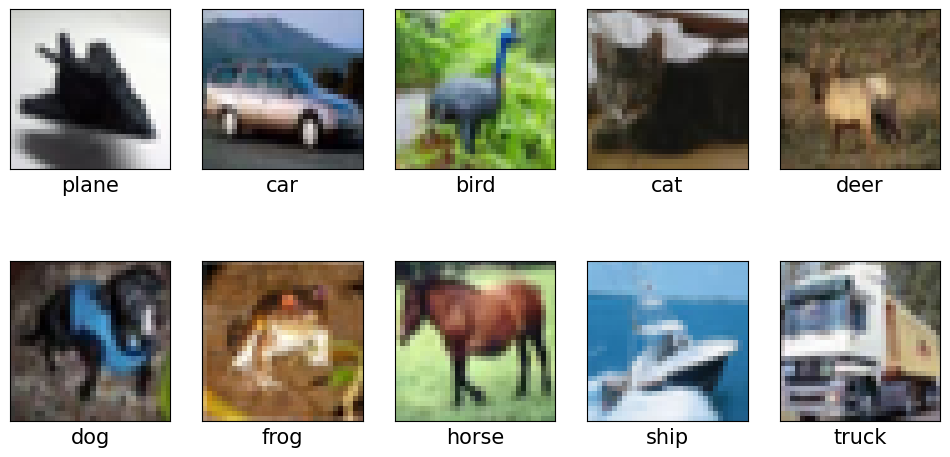

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Определим сверточную нейронную сеть

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.bn_conv1 = nn.BatchNorm2d(16)
        self.bn_conv2 = nn.BatchNorm2d(32)
        self.bn_fc1 = nn.BatchNorm1d(64)
        self.bn_fc2 = nn.BatchNorm1d(32)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout_conv = nn.Dropout2d(0.25)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = F.relu(self.bn_conv1(self.conv1(x)))
        out = self.pool(out)
        out = self.dropout_conv(out)

        out = F.relu(self.bn_conv2(self.conv2(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)

        out = torch.flatten(out, 1)  # flatten all dimensions except batch

        out = F.relu(self.bn_fc1(self.fc1(out)))
        out = self.dropout(out)

        out = F.relu(self.bn_fc2(self.fc2(out)))
        out = self.dropout(out)

        out = self.fc3(out)
        return out


net = Net().to(device)

In [5]:
total_params = sum(p.numel() for p in net.parameters())
print(f'Number of parameters: {total_params}')

Number of parameters: 138922


## Определим функцию потерь и алгоритм оптимизации

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0)

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Обучим нейронную сеть

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        loss_hist, acc_hist = {x: [] for x in ['train', 'val']}, {x: [] for x in ['train', 'val']}
        # loss_hist_val, acc_hist_val = [], []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'val':
                    scheduler.step(epoch_loss)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                loss_hist[phase].append(epoch_loss)
                acc_hist[phase].append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, loss_hist, acc_hist

In [ ]:
net, loss_hist, acc_hist = train_model(net, criterion, optimizer, scheduler)

In [ ]:
plt.plot(loss_hist["train"])
plt.plot(loss_hist["val"])

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=0)

In [ ]:
model, lh, ah = train_model(resnet, criterion, optimizer, scheduler)

## Проверка модели на тестовых данных